In [17]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
from scipy.stats import multivariate_normal
from scipy import fftpack
import astropy.constants as const
import astropy.units as u
import numpy as np
import cmasher
import sys
import pandas as pd
plt.rcParams['font.size']=18
plt.rcParams['font.style']='normal'


def format_axes(plax,cax,lx='dr (rad)',ly='dd (rad)',clabel='IM'):
    plax.set_xticklabels('')
    plax.set_yticklabels('')
    plax.set_xlabel(lx)
    plax.set_ylabel(ly)
    cax.xaxis.tick_top()
    cax.yaxis.set_ticks(())
    cax.xaxis.set_major_locator(plt.MaxNLocator(3))
    cax.set_xlabel(clabel,labelpad=-60)

def format_axes0(plax,lx='dr (rad)',ly='dd (rad)',clabel='IM'):
    plax.set_xticklabels('')
    plax.set_yticklabels('')
    plax.set_xlabel(lx)
    plax.set_ylabel(ly)

def plot_spectrum(grayscale_image,im_fft,wave=1e-3):
    # A logarithmic coormap
    aspect=plt.figaspect(0.5)
    f = plt.figure(figsize=aspect)
    left=0.15
    right=1.-left+0.05
    bottom=left
    top=1.-bottom
    grid = gs(1,2,wspace=0.3,hspace=0.3,
              #height_ratios=[0.05,1],
              left=left,right=right,top=top,bottom=bottom)
    ax0 = f.add_subplot(grid[0,0])
    ax1 = f.add_subplot(grid[0,1])
    #cax0 = f.add_subplot(grid[0,0])
    #cax1 = f.add_subplot(grid[0,1])
    pl0 = ax0.imshow(grayscale_image,alpha=None,
                     #cmap=cmasher.chroma,
                     interpolation='none'
                     )
    pl1 = ax1.imshow(im_fft,alpha=None,
                     #norm=plt.cm.colors.LogNorm(),
                     #cmap=cmasher.chroma,
                     interpolation='none',
                     )
    xticks0 = ax0.get_xticks()
    yticks0 = ax0.get_yticks()
    xticks1 = ax1.get_xticks()
    yticks1 = ax1.get_yticks()
    #cb0 = plt.colorbar(pl0,cax=cax0,orientation='horizontal')
    #cb1 = plt.colorbar(pl1,cax=cax1,orientation='horizontal')
    plax0 = pl0.axes
    plax1 = pl1.axes
    format_axes0(plax0,lx='dx (arcsec)',ly='dy (arcsec)')
    format_axes0(plax1,lx='log u (klambda)',ly='log v (klambda)',
                clabel='log(FT(IM))')
    #ax1.set_xticklabels(['{:.2g}'.format(t) for t in np.log10(np.array(xticks1)/wave)])
    #ax1.set_yticklabels(['{:.2g}'.format(t) for t in np.log10(np.array(xticks1)/wave)])
    #ax0.set_xticklabels(['{:.2f}'.format(t) for t in np.array((xticks0-np.max(xticks0/2))/np.pi*180/60/60)])
    #ax0.set_yticklabels(['{:.2f}'.format(t) for t in np.array((yticks0-np.max(yticks0/2))/np.pi*180/60/60)])
    #plt.tight_layout()
    return ax0,ax1

def plot_spectrum_with_ant(grayscale_image,im_fft,x_arr,y_arr):
    # A logarithmic coormap
    aspect=plt.figaspect(0.3)
    f = plt.figure(figsize=aspect)
    left=0.15
    right=1.-left+0.05
    bottom=left
    top=1.-bottom
    grid = gs(2,3,wspace=0.3,hspace=0.,
              height_ratios=[0.05,1],
              left=left,right=right,top=top,bottom=bottom)
    ax2 = f.add_subplot(grid[1,0])
    ax1 = f.add_subplot(grid[1,1])
    ax0 = f.add_subplot(grid[1,2])
    #cax0 = f.add_subplot(grid[0,0])
    #cax1 = f.add_subplot(grid[0,1])
    pl0 = ax0.imshow(grayscale_image,alpha=None,
                     #cmap=cmasher.chroma,
                     interpolation='none'
                     )
    xticks0 = ax0.get_xticks()
    yticks0 = ax0.get_yticks()
    pl1 = ax1.imshow(im_fft,alpha=None,
                     #norm=plt.cm.colors.LogNorm(),
                     #cmap=cmasher.chroma,
                     interpolation='none',
                     )
    xticks = ax1.get_xticks()
    yticks = ax1.get_yticks()
    pl2 = ax2.scatter(x_arr,y_arr)
    ax2.set_title('Antenna Location')
    ax2.set_xlabel('dx (km)')
    ax2.set_ylabel('dy (km)')
    ax2.set_xlim(-110,110)
    ax2.set_ylim(-110,110)
    #cb0 = plt.colorbar(pl0,cax=cax0,orientation='horizontal')
    #cb1 = plt.colorbar(pl1,cax=cax1,orientation='horizontal')
    plax0 = pl0.axes
    plax1 = pl1.axes
    format_axes0(plax0,lx='dr (arcsec)',ly='dd (arcsec)')
    format_axes0(plax1,lx='log u (wave)',ly='log v (wave)',
                clabel='log(FT(IM))')
    #ax1.set_xticklabels(['{:.2g}'.format(t) for t in np.log10(np.array(xticks*1e3)/wave)])
    #ax1.set_yticklabels(['{:.2g}'.format(t) for t in np.log10(np.array(xticks*1e3)/wave)])
    #ax0.set_xticklabels(['{:.2f}'.format(t) for t in np.array((xticks0-np.max(xticks0/2))/np.pi*180/60/60)])
    #ax0.set_yticklabels(['{:.2f}'.format(t) for t in np.array((yticks0-np.max(yticks0/2))/np.pi*180/60/60)])
    #plt.tight_layout()
    return ax0,ax1
    

def add_fourier_component(im,nx,ny,r,peak,angle):
    xr = int(np.sin(angle)*r)
    yr = int(np.cos(angle)*r)
    x0,y0 = int(nx/2-xr/2), int(ny/2-yr/2)
    x1,y1 = int(nx/2+xr/2), int(ny/2+yr/2)
    im[x0,y0] = peak
    im[x1,y1] = peak
    return im
    


# Define coordinate system, wcs of image

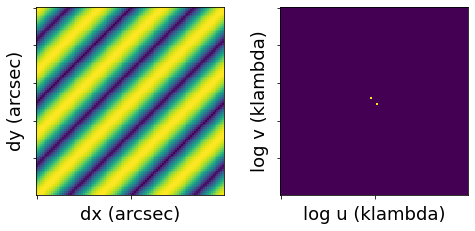

In [30]:
nx = 100
ny = 100
r = 5.
peak = 1
angle = np.pi/4.
im = np.zeros(nx*ny).reshape(nx,ny)
im = add_fourier_component(im,nx,ny,r,peak,angle)
im_fft = fftpack.fft2(im)
im_fft = np.nan_to_num(np.abs((im_fft)))

plot_spectrum(im_fft,im)
plt.show()
#plt.savefig('example_fft_toy_short.png',dpi=300,bbox_inches='tight')
#plt.close()



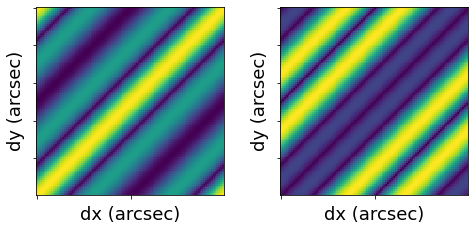

In [31]:
nx = 100
ny = 100
r = 5.
peak = 1
angle = np.pi/4.
im = np.zeros(nx*ny).reshape(nx,ny)
im = add_fourier_component(im,nx,ny,r,peak,angle)
im_fft = fftpack.fft2(im)
amp = np.nan_to_num(np.abs(np.real((im_fft))))
phase = np.nan_to_num(np.abs(np.imag((im_fft))))

# A logarithmic colormap
aspect=plt.figaspect(0.5)
f = plt.figure(figsize=aspect)
left=0.15
right=1.-left+0.05
bottom=left
top=1.-bottom
grid = gs(1,2,wspace=0.3,hspace=0.3,
          #height_ratios=[0.05,1],
          left=left,right=right,top=top,bottom=bottom)
ax0 = f.add_subplot(grid[0,0])
ax1 = f.add_subplot(grid[0,1])

pl0 = ax0.imshow(amp,alpha=None,
                 #cmap=cmasher.chroma,
                 interpolation='none'
                 )
pl1 = ax1.imshow(phase,alpha=None,
                 #norm=plt.cm.colors.LogNorm(),
                 #cmap=cmasher.chroma,
                 interpolation='none',
                 )
xticks0 = ax0.get_xticks()
yticks0 = ax0.get_yticks()
xticks1 = ax1.get_xticks()
yticks1 = ax1.get_yticks()

plax0 = pl0.axes
plax1 = pl1.axes
format_axes0(plax0,lx='dx (arcsec)',ly='dy (arcsec)')
format_axes0(plax1,lx='dx (arcsec)',ly='dy (arcsec)')
plt.show()
#plt.savefig('example_fft_toy_phase_amp.png',dpi=300,bbox_inches='tight')
#plt.close()


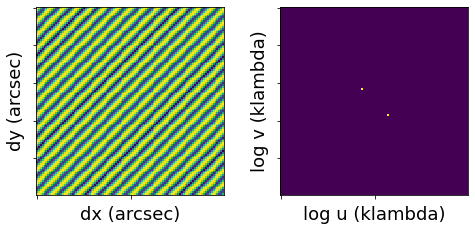

In [32]:

r = 20.
im = np.zeros(nx*ny).reshape(nx,ny)
im = add_fourier_component(im,nx,ny,r,peak,angle)
im_fft = fftpack.fft2(im)
im_fft = np.nan_to_num(np.abs((im_fft)))
plot_spectrum(im_fft,im)
plt.show()
#plt.savefig('example_fft_toy_long.png',dpi=300,bbox_inches='tight')
#plt.close()


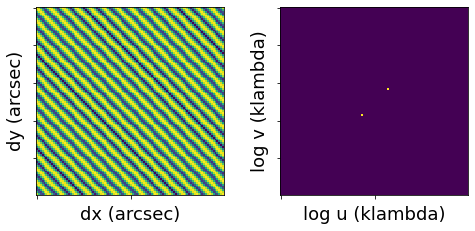

In [35]:


im = np.zeros(nx*ny).reshape(nx,ny)
angle = np.pi*3./4
im = add_fourier_component(im,nx,ny,r,peak,angle)
im_fft = fftpack.fft2(im)
im_fft = np.nan_to_num(np.abs((im_fft)))
plot_spectrum(im_fft,im)
plt.show()
#plt.savefig('example_fft_toy_angle.png',dpi=300,bbox_inches='tight')
#plt.close()



In [37]:

# multiple Antennas
def get_fourier_from_telescope(im,nx,ny,r,peak,angle):
    xr = int(np.sin(angle)*r)
    yr = int(np.cos(angle)*r)
    x0,y0 = int(nx/2-xr/2), int(ny/2-yr/2)
    x1,y1 = int(nx/2+xr/2), int(ny/2+yr/2)
    im[x0,y0] = peak
    im[x1,y1] = peak
    return x0,y0,x1,y1,im

# Gaussian beam
mu_x = 0.
sigma_x = 2.
mu_y = 0.
sigma_y = 2.
rv = multivariate_normal([mu_x, mu_y], [[sigma_x, 0], [0, sigma_y]])
xx = np.meshgrid(np.arange(-int(10*sigma_y),int(10*sigma_y)+1),np.arange(-int(10*sigma_x),int(10*sigma_x)+1))
pos = np.empty(xx[0].shape+(2,)).astype('int')
pos[:,:,0] = xx[0]
pos[:,:,1] = xx[1]
pd = rv.pdf(pos)
pd = pd/np.nanmax(pd)


x_arr=[]
y_arr=[]
for i in np.arange(60):
    r_=999
    while r_ > 100:
        x_=np.random.random()*10
        y_=np.random.random()*10
        r_ = np.sqrt((x_)**2+(y_)**2)

    x_arr.append(x_)
    y_arr.append(y_)
    
xy = np.meshgrid(x_arr,y_arr)
pairs = np.vstack([xy[0].ravel(),xy[1].ravel()]).T
pairs = np.unique(pairs,axis=0)
angle_init = np.arctan((pairs[:,0])/(pairs[:,1]))
angle_init = angle_init+np.pi/4
r_arr = np.sqrt((pairs[:,0]-nx/2)**2+(pairs[:,1]-ny/2)**2)

r_arr = np.random.random_sample(60)*100
angle_arr = np.random.random_sample(60)*2*np.pi

x_arr = r_arr*np.cos(angle_arr)
y_arr = r_arr*np.sin(angle_arr)

wave = 1e-3 # 1mm
im = np.zeros(nx*ny).reshape(nx,ny)
for r, angle in zip(r_arr,angle_arr):
    im = add_fourier_component(im,nx,ny,r,peak,angle)
    
#im_fft = fftpack.fft2(im)
#im_fft = np.nan_to_num(np.abs((im_fft)))
#out = convolve2d(im,pd)

mu_x = 0.
sigma_x = 25.
mu_y = 0.
sigma_y = 25.
rv = multivariate_normal([mu_x, mu_y], [[sigma_x, 0], [0, sigma_y]])
xx = np.meshgrid(np.arange(-int(im.shape[1]/2),int(im.shape[1]/2)),
                 np.arange(-int(im.shape[0]/2),int(im.shape[0]/2)))
pos = np.empty(xx[0].shape+(2,)).astype('int')
pos[:,:,0] = xx[0]
pos[:,:,1] = xx[1]
pb = rv.pdf(pos)
pb = pb/np.nanmax(pb)
#out = convolve2d(im,pb)

mu_x = 0.
sigma_x = 5.
mu_y = 0.
sigma_y = 5.
rv = multivariate_normal([mu_x, mu_y], [[sigma_x, 0], [0, sigma_y]])
xx = np.meshgrid(np.arange(-int(im.shape[1]/2),int(im.shape[1]/2)),
                 np.arange(-int(im.shape[0]/2),int(im.shape[0]/2)))
pos = np.empty(xx[0].shape+(2,)).astype('int')
pos[:,:,0] = xx[0]
pos[:,:,1] = xx[1]
source = rv.pdf(pos)
source = source/np.nanmax(source)*100



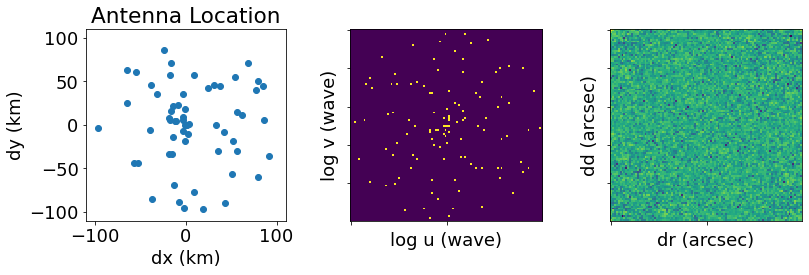

In [38]:
im_fft = fftpack.fft2(im)
im_fft = np.nan_to_num(np.abs((im_fft)))
plot_spectrum_with_ant(np.log10(im_fft),im,x_arr,y_arr)
plt.show()
#plt.savefig('example_fft_toy_60ants.png',dpi=300,bbox_inches='tight')
#plt.close()


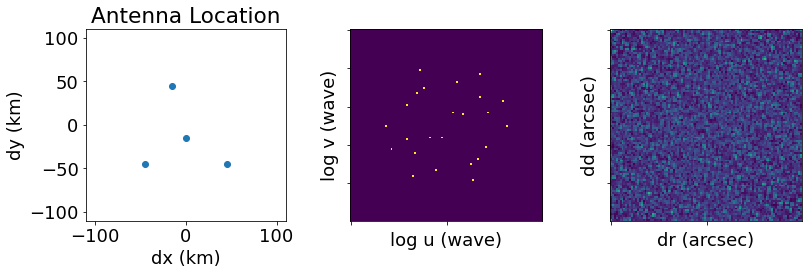

In [39]:

x_arr = np.array([-45,45,-15,0.])+int(nx/2)
y_arr = np.array([-45,-45,45,-15])+int(ny/2)
x_arr_ = x_arr-int(nx/2)
y_arr_ = y_arr-int(ny/2)

xy = np.meshgrid(x_arr,y_arr)
pairs = np.vstack([xy[0].ravel(),xy[1].ravel()]).T
pairs = np.unique(pairs,axis=0)
angle_init = np.arctan((pairs[:,0])/(pairs[:,1]))
angle_init = angle_init+np.pi/4
r_arr = np.sqrt((pairs[:,0]-nx/2)**2+(pairs[:,1]-ny/2)**2)

x_arr = r_arr*np.cos(angle_init)
y_arr = r_arr*np.sin(angle_init)
x_arr = np.round(x_arr,0)
y_arr = np.round(y_arr,0)
from scipy.signal import convolve2d

wave = 1e-3 # 1mm
im = np.zeros(nx*ny).reshape(nx,ny)
for r, angle in zip(r_arr,angle_arr):
    im = add_fourier_component(im,nx,ny,r,peak,angle)
#out = convolve2d(im,pd)
im_fft = fftpack.fft2(im)
im_fft = np.nan_to_num(np.abs((im_fft)))

plot_spectrum_with_ant(im_fft,im,x_arr_,y_arr_)
plt.show()
#plt.savefig('example_fft_toy_4ants.png',dpi=300,bbox_inches='tight')
#plt.close()


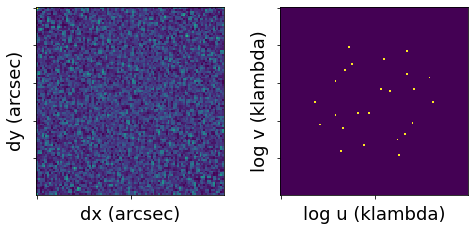

In [41]:


r = 1.
im = np.zeros(nx*ny).reshape(nx,ny)
for r, angle in zip(r_arr,angle_arr):
    im = add_fourier_component(im,nx,ny,r,peak,angle)
im_fft = fftpack.fft2(im)
im_fft = np.nan_to_num(np.abs((im_fft)))
plot_spectrum(im_fft,im)
plt.show()
#plt.savefig('example_fft_toy_single.png',dpi=300,bbox_inches='tight')
#plt.close()


# Model the Brightness Distribution of a Gaussian source

We start by modelling a two-dimensional Gaussian source in the sky, with arbitary coordinates for the time being.

<ipython-input-24-a34278c37af1>:42: RuntimeWarning: divide by zero encountered in log10
  ax00.imshow(np.log10(source),origin='lower',label='Source')
<ipython-input-24-a34278c37af1>:43: RuntimeWarning: divide by zero encountered in log10
  ax01.imshow(np.log10(vis),origin='lower',label='Source FFT')
No handles with labels found to put in legend.


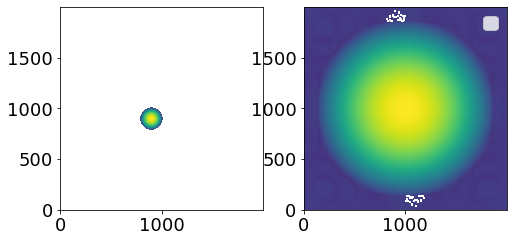

In [24]:
# choose arbitrary RA, Dec
coord = SkyCoord('12h01m53.170','-18d52m37.92')

nx = 1000
ny = 1000
peak = 100. # Jy
angle = np.pi/4.
im = np.zeros(nx*ny).reshape(nx,ny)

mu_x = -nx/2
sigma_x = 1
mu_y = -ny/2
sigma_y = 1
#rv = multivariate_normal([mu_x, mu_y], [[sigma_x, 0], [0, sigma_y]])
xx = np.meshgrid(np.arange(-nx,nx),
                 np.arange(-ny,ny))
pos = np.empty(xx[0].shape+(2,)).astype('int')
pos[:,:,0] = xx[0]
pos[:,:,1] = xx[1]
source = rv.pdf(pos)
source = source*peak

mu_x = -nx
sigma_x = 10
mu_y = -ny
sigma_y = 10
rv = multivariate_normal([mu_x, mu_y], [[sigma_x, 0], [0, sigma_y]])
xx = np.meshgrid(np.arange(-nx,nx),
                 np.arange(-ny,ny))
pos = np.empty(xx[0].shape+(2,)).astype('int')
pos[:,:,0] = xx[0]
pos[:,:,1] = xx[1]
pb = rv.pdf(pos)
pb = pb/np.nanmax(pb)

#source = makeGaussian(100., fwhm = 1,center=None)
vis = fftpack.fftshift(fftpack.fft2(source))
vis = np.abs(vis)

figsize = plt.figaspect(0.5)
f0 = plt.figure(figsize=figsize)
grid=gs(1,2)
ax00 = f0.add_subplot(grid[0])
ax01 = f0.add_subplot(grid[1])
ax00.imshow(np.log10(source),origin='lower',label='Source')
ax01.imshow(np.log10(vis),origin='lower',label='Source FFT')
#plt.legend()
#ax00.set_xlim(0,100)
#ax00.set_ylim(0,100)
#ax01.set_xlim(-100,100)
#ax01.set_ylim(-100,100)



# Create a telescope array

We then construct a telescope array.

In [9]:
# Telescope array

# read in telescope coordinates
names = ['x','y','z','diam','pad']
config = pd.read_csv('alma.cycle7.5.cfg',
                     sep='\s+',
                     skiprows=3,
                     names=names)
print(config)
#im = np.zeros_like(vis)
x_arr = config['x'].values
y_arr = config['y'].values

             x            y          z  diam   pad
0    15.934535  -700.675748  -2.329676  12.0  A007
1    37.826178  -735.876082  -2.484749  12.0  A011
2    10.739879  -659.567364  -2.726262  12.0  A015
3   -43.644072  -652.742461  -2.322697  12.0  A022
4   -74.474616  -684.657459  -2.129343  12.0  A024
5   -93.142925  -745.959481  -1.941493  12.0  A027
6  -105.438738  -755.003357  -1.640753  12.0  A033
7     2.382623  -763.285557  -2.838873  12.0  A042
8    17.105372  -766.533803  -2.842287  12.0  A043
9   -63.505212  -786.819957  -1.341061  12.0  A045
10  -19.653997  -794.595231  -2.338743  12.0  A047
11  -45.350247  -846.397206  -1.848567  12.0  A058
12   -5.289168  -862.853826  -1.546623  12.0  A060
13  -79.543802  -828.939797  -1.295599  12.0  A062
14  -54.711817  -616.689221  -2.521178  12.0  A066
15 -140.507228  -651.164080  -0.634931  12.0  A068
16 -159.551608  -789.469025  -0.085067  12.0  A069
17  108.097794  -762.866636  -4.094737  12.0  A070
18   89.093953  -599.959700  -5

# Calculate baseline and visibility information

Some variables:
* $\theta$: angle of the source in the sky with respect to the azimuth
* $c \tau_g$: difference in path length that a light wave with speed $c$ will travel in time $\tau_g$
* $B$: baseline distance

The geoemtric delay of the signal between a pair of telescopes is also equivalent to:
$c\tau_g = B \mathrm{sin}\theta$

The combined, correlated voltage signal from a pair of telescopes is given by: $V = E^2[1 + \mathrm{cos}(2\pi\nu\tau_g)]$, where $E$ is the amplitude dependent on the strength of our source. Accounting for the time delay, we get the fringe function for a signal with wavelength $\theta$:
$F = E^2\left[1 + \mathrm{cos}\left(\frac{2\pi B\mathrm{sin}\theta}{\lambda}\right)\right]$

For an array of 60 antennas, we get $N(N-1)/2=1770$ baselines.

<ipython-input-20-a49aad30bffc>:30: RuntimeWarning: divide by zero encountered in true_divide
  B_angle = np.arctan((y_arr[ij[:,0]]-y_arr[ij[:,1]])/(x_arr[ij[:,0]]-x_arr[ij[:,1]]))


NameError: name 'vis' is not defined

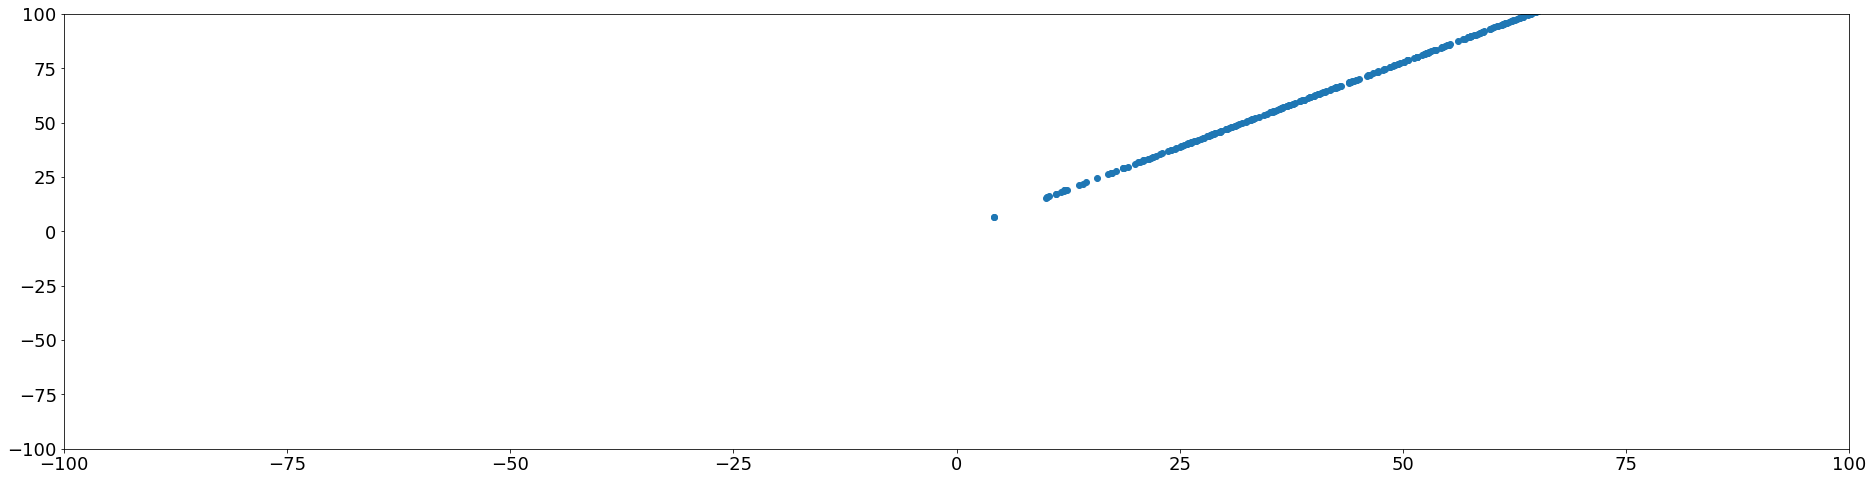

In [20]:
# For an array of 60 antennae
x_arr = x_arr.astype('int')
y_arr = y_arr.astype('int')

# Pick an arbitraty angle for source
theta = 45.*np.pi/180. # angle of source w.r.t. azimuth, must be in radians

# Calulate baseline lengths of telescope pairs
a_arr = np.ones_like(x_arr)
grid = np.meshgrid(x_arr, y_arr)
k=0
ij = []
for i in np.arange(len(x_arr)):
    for j in np.arange(i+1,len(y_arr)):
        ij.append((i,j))

ij = np.vstack(ij)
B = np.sqrt((x_arr[ij[:,0]]-x_arr[ij[:,1]])**2 + (y_arr[ij[:,0]]-y_arr[ij[:,1]])**2)*u.m # meters

# Calculate time delay between individual telescopes, in seconds
tau_g = B*np.sin(theta)/const.c

# Calculte the voltage signal from a pair of

#pairs = pairs[0].ravel(),pairs[1].ravel()
#print(grid[0].ravel(),grid[1].ravel())
#print(pairs)


B_angle = np.arctan((y_arr[ij[:,0]]-y_arr[ij[:,1]])/(x_arr[ij[:,0]]-x_arr[ij[:,1]]))

u_arr0 = B/2*np.cos(a_arr[ij[:,0]])
v_arr0 = B/2*np.sin(a_arr[ij[:,0]])
u_arr1 = B/2*np.cos(a_arr[ij[:,1]])
v_arr1 = B/2*np.sin(a_arr[ij[:,1]])

figsize = plt.figaspect(0.25)
f2 = plt.figure(figsize=figsize*2)
ax2 = f2.add_subplot(111)
ax2.scatter(u_arr0,v_arr0,c='C0')
#ax2.scatter(u_arr1,v_arr1,c='C1')
ax2.set_xlim(-100,100)
ax2.set_ylim(-100,100)

# Calculate amplitude of visibilities
pairs = np.vstack([(int(x_),int(y_)) for x_,y_ in zip(x_arr,y_arr)])
data = vis*(1+np.cos(2*np.pi*B*np.pi/4/1e-3))
image = fftpack.ifftshift(fftpack.ifft2(data))
image = np.abs(image)


f1 = plt.figure(figsize=figsize)
grid = gs(1,4)
ax10 = f1.add_subplot(grid[0])
ax11 = f1.add_subplot(grid[1])
ax12 = f1.add_subplot(grid[2])
ax13 = f1.add_subplot(grid[3])

ax10.scatter(x_arr,y_arr)
ax11.imshow(uv,norm=plt.cm.colors.LogNorm(),origin='lower')
ax12.imshow(data,norm=plt.cm.colors.LogNorm(),origin='lower')
ax13.imshow(image,norm=plt.cm.colors.LogNorm(),origin='lower')

In [ ]:
#fft_source = fftpack.fft2(source)
#fft_source = np.abs(fft_source)
sky = convolve2d(uv,source)
f3 = plt.figure(figsize=figsize*2)
ax3 = f3.add_subplot(111)
ax3.imshow(sky)

In [ ]:
data = fftpack.fft2(sky)
data = np.abs(data)
f5 = plt.figure(figsize=figsize*2)
ax5 = f5.add_subplot(111)
ax5.imshow(data,norm=plt.cm.colors.LogNorm())